In [1]:
import nltk
#nltk.download('cess_esp')
from nltk.corpus import cess_esp
#from sklearn.model_selection import train_test_split
from nltk.tag import UnigramTagger,BigramTagger,hmm, tnt, AffixTagger,brill, brill_trainer, CRFTagger
from math import sqrt
from random import shuffle
import pandas as pd
from nltk.tag.perceptron import PerceptronTagger


In [2]:
def accuracy95(p,ndatos):
    return 1.95*sqrt(p*(1-p) /ndatos)

In [3]:
def scuadrado(values):
    media = sum(values)/len(values)
    scuadrado = sum([(value-media)**2 for value in values]) / len(values)
    res = "[%.4f, %.4f]" %(media-scuadrado,media+scuadrado)
    return res

In [4]:
def scuadrado2(values):
    media = sum(values)/len(values)
    scuadrado = sum([(value-media)**2 for value in values]) / len(values)
    return round(media*100,2), round(scuadrado*100,2)

Cargamos el corpus, lo reducimos y lo barajamos

In [5]:
corpus = list(cess_esp.tagged_sents())

In [6]:
len(corpus)

6030

In [6]:
corpus_reducido = []
for oracion in corpus:
    aux = []
    for palabra,categoria in oracion:
        if palabra !="*0*":
            aux.append((palabra,categoria[0:3]) if categoria[0] == "v" or categoria[0] == "F" else (palabra,categoria[0:2]))
    corpus_reducido.append(aux)

In [7]:
corpus_barajado = corpus.copy()
corpus_reducido_barajado =corpus_reducido.copy()
shuffle(corpus_barajado)
shuffle(corpus_reducido_barajado)

## Tarea 1

In [8]:
def cross_validation(clasificador,k,datosParticionados):
    precisiones = []
    for i in range(k):
        train = datosParticionados.copy()
        test = train[i]
        del train[i]
        train = [val for sublist in train for val in sublist]#Aplano las listas de listas de listas
        tagger = clasificador.train(train[0:-1])
        precisiones.append(tagger.evaluate(test))
    return precisiones

In [9]:
k = 10
tamañoParticion = int(len(corpus_barajado)/k)
tamañoParticionReducido = int(len(corpus_reducido_barajado)/k)
corpusParticionado = [corpus_barajado[i*tamañoParticion :i*tamañoParticion +tamañoParticion] for i in range(k)]
corpusReducidoParticionado = [corpus_reducido_barajado[i*tamañoParticionReducido :i*tamañoParticionReducido +tamañoParticionReducido] for i in range(k)]



In [10]:
precisiones_HMM_completo = cross_validation(hmm.HiddenMarkovModelTagger,10,corpusParticionado)
precision_HMM_reducido  = cross_validation(hmm.HiddenMarkovModelTagger,10,corpusReducidoParticionado)

In [11]:
intervalos_HMM_completo = [accuracy95(p,tamañoParticion) for p in precisiones_HMM_completo]
intervalos_HMM_reducido = [accuracy95(p,tamañoParticionReducido) for p in precision_HMM_reducido]

In [12]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precisiones_HMM_completo
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM completed')
plt.plot(x,y,'ro')
Tic=intervalos_HMM_completo# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

<Figure size 640x480 with 1 Axes>

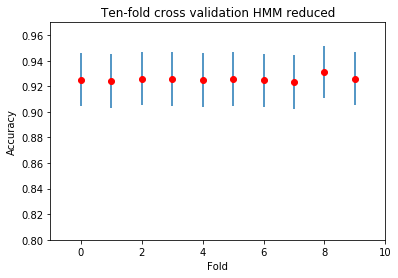

In [13]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precision_HMM_reducido
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM reduced')
plt.plot(x,y,'ro')
Tic=intervalos_HMM_reducido# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

In [14]:
datosCorpusCompleto = {"precicisiones":precisiones_HMM_completo,"intervalos":intervalos_HMM_completo }
datosCorpusReducido = {"precicisiones":precision_HMM_reducido,"intervalos":intervalos_HMM_reducido }
dataFrameCompleto = pd.DataFrame(datosCorpusCompleto)
dataFrameReducido = pd.DataFrame(datosCorpusReducido)

In [15]:
dataFrameCompleto.to_latex(index=False)

'\\begin{tabular}{rr}\n\\toprule\n precicisiones &  intervalos \\\\\n\\midrule\n      0.896778 &    0.024160 \\\\\n      0.895756 &    0.024266 \\\\\n      0.892259 &    0.024621 \\\\\n      0.897245 &    0.024112 \\\\\n      0.898711 &    0.023959 \\\\\n      0.893819 &    0.024464 \\\\\n      0.904184 &    0.023373 \\\\\n      0.896589 &    0.024180 \\\\\n      0.896548 &    0.024184 \\\\\n      0.899536 &    0.023872 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [16]:
dataFrameReducido.to_latex(index=False)

'\\begin{tabular}{rr}\n\\toprule\n precicisiones &  intervalos \\\\\n\\midrule\n      0.925289 &    0.020879 \\\\\n      0.924314 &    0.021004 \\\\\n      0.925920 &    0.020798 \\\\\n      0.925744 &    0.020820 \\\\\n      0.924755 &    0.020947 \\\\\n      0.925717 &    0.020824 \\\\\n      0.924569 &    0.020971 \\\\\n      0.923337 &    0.021128 \\\\\n      0.931255 &    0.020092 \\\\\n      0.926029 &    0.020784 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
print("Cross validation HMM completed %s" %(scuadrado(precisiones_HMM_completo)) )
print("Cross validation HMM reduced %s" %(scuadrado(precision_HMM_reducido)) )

Cross validation HMM completed [0.8971, 0.8972]
Cross validation HMM reduced [0.9257, 0.9257]


# Tarea 2

In [18]:
testCompleto = corpusParticionado[-1]
precisionesCompleto = []
for i in range(1,len(corpusParticionado)):
    elTodo = corpusParticionado[0:i]
    trainCompleto = []
    for particion in elTodo:
        trainCompleto+=particion
    tagger = hmm.HiddenMarkovModelTagger.train(trainCompleto)
    precision = tagger.evaluate(testCompleto) 
    precisionesCompleto.append(precision)
    

In [19]:
testReducido = corpusReducidoParticionado[-1]
precisionesReducido = []
for i in range(1,len(corpusReducidoParticionado)):
    elTodo = corpusReducidoParticionado[0:i]
    trainCompleto = []
    for particion in elTodo:
        trainCompleto+=particion
    tagger = hmm.HiddenMarkovModelTagger.train(trainCompleto)
    precision = tagger.evaluate(testReducido) 
    precisionesReducido.append(precision)
    

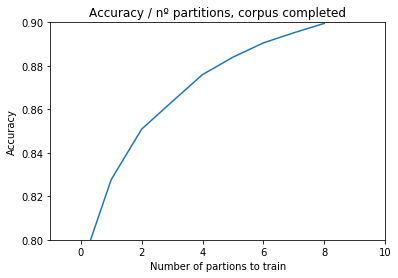

In [20]:
import matplotlib.pyplot as plt
x=[i for i in range(9)]
results=precisiones_HMM_completo
y=precisionesCompleto # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.90])
plt.ylabel('Accuracy')
plt.xlabel('Number of partions to train')
plt.title('Accuracy / nº partitions, corpus completed')
plt.plot(x,y)
plt.show()

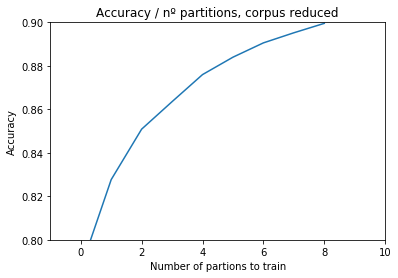

In [21]:
import matplotlib.pyplot as plt
x=[i for i in range(9)]
results=precision_HMM_reducido
y=precisionesCompleto # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.90])
plt.ylabel('Accuracy')
plt.xlabel('Number of partions to train')
plt.title('Accuracy / nº partitions, corpus reduced')
plt.plot(x,y)
plt.show()

# Tarea 3

In [22]:
precisionesPorSufijo = []
for lenSufix in range(0, 5):
    precisiones_TNT = []
    for i in range(10):
        train = corpusReducidoParticionado.copy()
        test = train[i]
        del train[i]
        train = [val for sublist in train for val in sublist] #aplanamos la lista
        sufix_tagger = AffixTagger(train, affix_length=-lenSufix)
        tagger_TNT = tnt.TnT(N=100, unk=sufix_tagger, Trained=True)
        tagger = tagger_TNT.train(train)
        precisiones_TNT.append(tagger_TNT.evaluate(test))
    precisionesPorSufijo.append(precisiones_TNT)


In [23]:
precisionesMediaPorSufijo = [scuadrado2(precisiones) for precisiones in precisionesPorSufijo]
print(precisionesMediaPorSufijo)

[(90.18, 0.0), (92.96, 0.0), (93.91, 0.0), (94.73, 0.0), (94.45, 0.0)]


[0.9018, 0.9296, 0.9390999999999999, 0.9473, 0.9445]


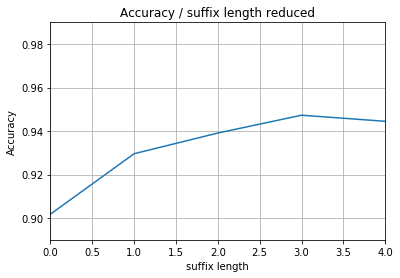

In [24]:
import matplotlib.pyplot as plt
x=[i for i in range(5)]
results=[p/100 for p,q in precisionesMediaPorSufijo]
print(results)
y=results # results es una lista con los resultados de cada experimento
plt.axis([-0, 4, 0.89, 0.99])
plt.ylabel('Accuracy')
plt.xlabel('suffix length')
plt.title('Accuracy / suffix length reduced')
plt.plot(x,y)
plt.grid()
plt.show()

# Tarea 4

In [25]:
lenCorpusTok = len(corpus_reducido_barajado)
train=corpus_reducido_barajado[:9*lenCorpusTok//10]
test=corpus_reducido_barajado[9*lenCorpusTok//10:]

In [26]:
tagger_unigramas = UnigramTagger(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
tagger1 = trainer.train(train, max_rules=1000)
tagger1.evaluate(test)

TBL train (fast) (seqs: 5427; tokens: 169363; tpls: 37; min score: 2; min acc: None)
Finding initial useful rules...
    Found 106346 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
10591192 133   0  | pr->cs if Pos:vmi@[-3,-2,-1]
 236 254  18   0  | da->pp if Pos:vmi@[1]
 216 307  91   0  | pr->cs if Word:que@[0] & Pos:sp@[-1]
 186 348 162   9  | nc->aq if Pos:nc@[-1]
  98 125  27   0  | pr->cs if Pos:vai@[-3,-2,-1]
  89 109  20   7  | di->pi if Pos:sp@[1]
  87  96   9   0  | aq->vmp if Pos:vai@[-1]
  85 130  45   0  | pr->cs if Pos:rg@[-2,-1]
  75  76   1   0  | pr->cs if Word:que@[0] & Pos:vmn@[-1]
  63  69   6   0  | vmp->aq if Pos

   4   4   0   0  | vsi->vmi if Word:se@[-1]
   4   4   0   0  | aq->nc if Pos:dd@[-1] & Pos:Fc@[1]
   4   9   5   0  | aq->nc if Pos:di@[-1] & Pos:aq@[1]
   4   4   0   0  | pi->di if Pos:pp@[-1] & Pos:vmi@[1]
   4   4   0   0  | cs->pr if Pos:rg@[-1] & Pos:da@[-2]
   4   4   0   1  | di->pi if Pos:vai@[1]
   4   4   0   0  | vmp->aq if Pos:np@[-1]
   4   4   0   0  | vmp->nc if Pos:di@[-1]
   4   5   1   0  | pr->cs if Pos:np@[1] & Word:que@[0] & Word:y@[-1]
   3   3   0   0  | rg->cc if Word:sin_embargo@[0] & Word:,@[1] & Word:el@[2]
   3   3   0   0  | aq->nc if Word:el@[-1] & Word:pleno@[0] & Word:del@[1]
   3   5   2   0  | cs->pr if Word:en@[-1] & Word:que@[0] & Word:se@[1]
   3   3   0   0  | nc->sp if Word:local@[-1] & Word:vía@[0] & Word:radio@[1]
   3   3   0   0  | aq->nc if Word:argentino@[0] & Word:el@[-1]
   3   3   0   0  | aq->nc if Word:brasileño@[0] & Word:al@[-1]
   3   3   0   0  | aq->nc if Word:español@[0] & Word:el@[-1]
   3   3   0   0  | aq->nc if Word:estadou

   2   2   0   0  | dd->nc if Word:-Fpa-@[-1] & Word:este@[0] & Word:-Fpt-@[1]
   2   2   0   0  | dn->pn if Word:los@[-1] & Word:seis@[0] & Word:primeros@[1]
   2   2   0   0  | dn->pn if Word:son@[-1] & Word:tres@[0] & Word:los@[1]
   2   2   0   0  | nc->W if Word:el@[-1] & Word:mes@[0] & Word:pasado@[1]
   2   2   0   0  | nc->aq if Word:,@[-1] & Word:propietaria@[0] & Word:de@[1]
   2   2   0   0  | nc->vmi if Word:los@[-1] & Word:diferencia@[0] &
                  |   Word:es@[1]
   2   2   0   0  | nc->vmi if Word:que@[-1] & Word:falta@[0] & Word:para@[1]
   2   2   0   0  | pi->di if Word:fue@[-1] & Word:una@[0] & Word:de@[1]
   2   2   0   0  | pp->p0 if Word:y@[-1] & Word:me@[0] & Word:siento@[1]
   2   2   0   0  | pr->cs if Word:"@[-1] & Word:que@[0] & Word:las@[1]
   2   2   0   0  | pr->cs if Word:y@[-1] & Word:que@[0] & Word:es@[1]
   2   2   0   0  | pr->cs if Word:y@[-1] & Word:que@[0] &
                  |   Word:probablemente@[1]
   2   2   0   0  | pr->cs if Word:y@

   2   2   0   0  | aq->rg if Word:claro@[0] & Pos:pp@[-2]
   2   2   0   0  | aq->vmp if Word:incluido@[0] & Pos:np@[-2]
   2   7   5   0  | cc->cs if Word:mientras_que@[0] & Pos:aq@[-2]
   2   2   0   0  | nc->aq if Word:complejo@[0] & Pos:sp@[-2]
   2   2   0   0  | pn->nc if Word:medio@[0] & Pos:vmi@[-2]
   2   2   0   0  | vms->vmm if Word:dejen@[0] & Pos:np@[-2]
   2   2   0   0  | aq->nc if Word:médico@[0] & Pos:aq@[1]
   2   2   0   0  | aq->nc if Word:oficiales@[0] & Pos:sp@[1]
   2   2   0   0  | aq->vmp if Word:considerado@[0] & Pos:aq@[1]
   2   2   0   0  | dn->pn if Word:dos@[0] & Pos:di@[1]
   2   2   0   0  | pi->aq if Word:propio@[0] & Pos:sp@[1]
   2   2   0   0  | rg->cc if Word:sin_embargo@[0] & Pos:rg@[1]
   2   2   0   0  | sp->rg if Word:cerca_de@[0] & Pos:Z@[1]
   2   2   0   0  | sp->rg if Word:hasta@[0] & Pos:vmi@[1]
   2   2   0   0  | aq->dd if Word:semejante@[0] & Pos:sp@[-1]
   2   2   0   0  | aq->nc if Word:clave@[0] & Pos:nc@[-1]
   2   3   1   0  | aq-

0.8993827160493827

In [27]:
tagger_unigramas = hmm.HiddenMarkovModelTagger.train(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
tagger1 = trainer.train(train, max_rules=1000)
tagger1.evaluate(test)

TBL train (fast) (seqs: 5427; tokens: 169363; tpls: 37; min score: 2; min acc: None)
Finding initial useful rules...
    Found 131410 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  69  79  10   0  | sp->cs if Word:como@[0]
  32  64  32  46  | Fg->nc if Pos:Fg@[-1] & Pos:Fg@[1]
  32  32   0   0  | nc->Fg if Word:-@[0]
  29  32   3   0  | pr->cs if Word:que@[0] & Word:de@[-1]
  23  28   5   0  | cs->pr if Pos:sp@[1] & Word:que@[0] & Word:,@[-1]
  20  20   0   9  | vmp->nc if Word:hay@[-2,-1]
  20  20   0  10  | da->aq if Word:del@[-1]
  15  15   0   0  | cs->pr if Word:que@[0] & Word:al@[-1]
  15  15   0   0  | rg->pp if Word:sí@[0] &

   2   2   0   0  | cs->pr if Word:que@[0] & Word:se@[1] & Word:trate@[2]
   2   2   0   0  | cs->sp if Word:según@[0] & Word:él@[1] & Word:,@[2]
   2   2   0   0  | da->aq if Word:eventuales@[0] & Word:incidentes@[1] &
                  |   Word:que@[2]
   2   2   0   0  | da->pp if Word:los@[0] & Word:diferencia@[1] & Word:es@[2]
   2   2   0   0  | nc->Z if Word:9,16@[0] & Word:de@[1] & Word:la@[2]
   2   2   0   0  | nc->aq if Word:restantes@[0] & Word:1.115.856@[1] &
                  |   Word:contrataciones@[2]
   2   2   0   0  | nc->np if Word:Comunidades@[0] & Word:con@[1] &
                  |   Word:otras@[2]
   2   2   0   0  | nc->np if Word:Fab_Five@[0] & Word:-@[1] & Word:,@[2]
   2   2   0   0  | np->Z if Word:27.050@[0] & Word:fueron@[1] & Word:otro@[2]
   2   2   0   0  | p0->pp if Word:se@[0] & Word:conocían@[1] & Word:,@[2]
   2   2   0   0  | pr->Z if Word:80.206@[0] & Word:se@[1] &
                  |   Word:realizaron@[2]
   2   2   0   0  | pr->cs if Word:que@[0

   2   2   0   0  | pr->cs if Word:que@[0] & Word:martes@[-2]
   2   4   2   0  | pr->cs if Word:que@[0] & Word:otra@[-2]
   3   3   0   1  | cs->pr if Word:ciudad@[-2,-1]
   2   2   0   0  | pr->cs if Word:que@[0] & Word:sin_embargo@[-2]
   2   2   0   0  | vmp->aq if Word:llegado@[0] & Word:años@[-2]
   2   2   0   1  | Fp->np if Word:fue@[1,2]
   2   2   0   0  | ao->W if Word:GMT@[1,2]
   2   2   0   0  | cs->pr if Word:colocó@[1,2]
   2   2   0   0  | np->nc if Word:alquenos@[1,2]
   2   2   0   0  | np->nc if Word:transmisión@[1,2]
   2   2   0   0  | pr->nc if Word:significa@[1,2]
   2   2   0   0  | vmp->aq if Word:olvidar@[1,2]
   2   2   0   0  | Fpt->aq if Word:Bulgaria@[-2,-1]
   2   2   0   0  | Fpt->aq if Word:Fuerzas_Armadas@[-2,-1]
   2   2   0   1  | Fpt->np if Word:EFE@[-2,-1]
   2   2   0   0  | np->nc if Word:/@[1,2]
   2   2   0   0  | Fpt->np if Word:ETA@[-2,-1]
   2   2   0   0  | Z->nc if Word:tipo@[-2,-1]
   2   2   0   0  | aq->nc if Word:holandés@[-2,-1]
   2

0.9299897119341564

In [28]:
pt = PerceptronTagger(load=False)
pt.train(train)
pt.evaluate(test)

0.9679012345679012